In [17]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage, AIMessage
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict, Literal, Optional
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.types import Command


In [18]:
@tool
def get_weather_forecast(city: str, date: str) -> str:
    """Get the weather forecast for a city on a specific date."""
    # In a real implementation, this would call a weather API
    weather_data = {
        "New York": "sunny",
        "Los Angeles": "sunny",
        "Chicago": "cloudy",
        "Miami": "sunny",
        "London": "rainy",
        "Paris": "cloudy",
        "Tokyo": "sunny"
    }
    
    if city in weather_data:
        conditions = weather_data[city]

        return f"The weather in {city} on {date} is forecasted to be {conditions}."
    else:
        return f"Weather forecast for {city} is not available."
    

@tool
def search_flights(origin: str, destination: str, date: str) -> str:
    """Search for flights between two cities on a specific date, taking user preferences into account."""
    # In a real implementation, this would call a flight search API
    flight_options = [
        {
            "airline": "SkyWays",
            "departure_time": "08:00",
            "arrival_time": "10:30",
            "price": 350.00,
            "direct": True
        },
        {
            "airline": "OceanAir",
            "departure_time": "12:45",
            "arrival_time": "15:15",
            "price": 275.50,
            "direct": True
        },
        {
            "airline": "MountainJet",
            "departure_time": "16:30",
            "arrival_time": "21:45",
            "price": 225.75,
            "direct": False
        }
    ]
    flight_options = [option for option in flight_options if option["direct"]]
    if not flight_options:
       return "No direct flights available."
    return f"Found {flight_options} direct flights from {origin} to {destination} on {date}."


@tool
def search_hotels(city: str, max_price: Optional[float] = None) -> str:
    """Search for hotels in a city for specific dates within a price range, taking user preferences into account."""
    # In a real implementation, this would call a hotel search API
    hotel_options = [
        {
            "name": "City Center Hotel",
            "location": "Downtown",
            "price_per_night": 199.99,
            "amenities": ["WiFi", "Pool", "Gym", "Restaurant"]
        },
        {
            "name": "Riverside Inn",
            "location": "Riverside District",
            "price_per_night": 149.50,
            "amenities": ["WiFi", "Free Breakfast", "Parking"]
        },
        {
            "name": "Luxury Palace",
            "location": "Historic District",
            "price_per_night": 349.99,
            "amenities": ["WiFi", "Pool", "Spa", "Fine Dining", "Concierge"]
        }
    ]

    hotel_options = [hotel for hotel in hotel_options if hotel["price_per_night"] <= max_price] if max_price else hotel_options

    if not hotel_options:
        return "No hotels found."

    return f"Found {hotel_options} hotels in {city}"



In [19]:
#define a state class for the graph

system_prompt_for_router = """You are a travel planner agent. You can help users with travel-related queries.
                    Breakdown the user querry into action which the user need to do. 
                    The actions must be one of the following: travel_search, hotel_search, flight_search.
                    only output the action name and nothing else"""

class OutputStructure(BaseModel):
    action: Literal["weather_check", "hotel_search", "travel_search"]

class TravelPlannerState(TypedDict):
    user_query: str
    messages: Annotated[list[AnyMessage], add_messages]
    agent_redirect: Literal["weather_check", "hotel_search", "travel_search"]


#define my graph nodes - main router which takes querries and decides which agent to redirect
def main_router(state: TravelPlannerState) -> TravelPlannerState:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
    llm_structured = llm.with_structured_output(OutputStructure)
    response = llm_structured.invoke([
        SystemMessage(content=system_prompt_for_router),HumanMessage(content=state['user_query'])])

    state['messages'].append(HumanMessage(content=state['user_query']))

    state['agent_redirect'] = response.action
    return state

In [20]:
#define the node for travel_search
def travel_search(state: TravelPlannerState) -> TravelPlannerState:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

    agent = create_react_agent(model=llm, tools=[search_flights])

    travel_agent_system_prompt = """
    You are a travel agent. You can help users find flights. you have a tool for searching flights. use it if required
    """

    response = agent.invoke({"messages": [
        SystemMessage(content=travel_agent_system_prompt), HumanMessage(content=state['user_query'])]})

    state['messages'].extend(response['messages'][-3:])

    return state


#define the node for hotel_search
def hotel_search(state: TravelPlannerState) -> TravelPlannerState:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

    agent = create_react_agent(model=llm, tools=[search_hotels])

    hotel_agent_system_prompt = """
    You are a hotel booking agent. You can help users find hotels. You have a tool for searching hotels. Use it if required.
    """

    response = agent.invoke({"messages": [
        SystemMessage(content=hotel_agent_system_prompt), HumanMessage(content=state['user_query'])]})

    state['messages'].extend(response['messages'][-3:])

    return state


# Define the node weather check
def weather_check(state: TravelPlannerState) -> TravelPlannerState:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

    agent = create_react_agent(model=llm, tools=[get_weather_forecast])

    weather_agent_system_prompt = """
    You are a weather agent. You can help users check the weather. You have a tool for checking the weather. Use it if required.
    """

    response = agent.invoke({"messages": [
        SystemMessage(content=weather_agent_system_prompt), HumanMessage(content=state['user_query'])]})

    state['messages'].extend(response['messages'][-3:])

    return state


In [21]:
#create the graph

graph = StateGraph(TravelPlannerState)
graph.add_node("main_router", main_router)
graph.add_node("travel_search", travel_search)
graph.add_node("hotel_search", hotel_search)
graph.add_node("weather_check", weather_check)

graph.add_edge(START, "main_router")

def route(state: TravelPlannerState):
    return state["agent_redirect"]  # e.g. "travel_search" | "hotel_search" | "weather_check"

graph.add_conditional_edges(
    "main_router",
    route,  # <-- condition (callable)
    {
        "travel_search": "travel_search",
        "hotel_search": "hotel_search",
        "weather_check": "weather_check",
        # Optional default:
        # "__end__": END
    },
)
graph.add_edge("travel_search", END)
graph.add_edge("hotel_search", END)
graph.add_edge("weather_check", END)

app = graph.compile()


In [22]:
result = app.invoke({
    "user_query": "Find me a flight from New York to San Francisco on friday",
    "messages": []           # <-- needed so .append(...) in main_router works
})

result

{'user_query': 'Find me a flight from New York to San Francisco on friday',
 'messages': [HumanMessage(content='Find me a flight from New York to San Francisco on friday', additional_kwargs={}, response_metadata={}, id='ebd62909-229e-423b-9de7-d882c7c0e56e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7Ue5Xtz5RmIS5DLnplicYHvD', 'function': {'arguments': '{"origin":"New York","destination":"San Francisco","date":"2023-10-27"}', 'name': 'search_flights'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 103, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C6uygHLuCNJMGr471YhWikt4M3rg8', 'finish_reason': 'tool_calls', 'logpro

In [24]:
result2 = app.invoke({
    "user_query": "Find me a hotel in San Francisco. my budget is 200 dollars"
})

result2

{'user_query': 'Find me a hotel in San Francisco. my budget is 200 dollars',
 'messages': [HumanMessage(content='Find me a hotel in San Francisco. my budget is 200 dollars', additional_kwargs={}, response_metadata={}, id='92f2370d-a604-409f-9637-1b9cd82ae226'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8OuVsrHcWfOrhFrTwGQT6N0M', 'function': {'arguments': '{"city":"San Francisco","max_price":200}', 'name': 'search_hotels'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 115, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C6uyt25q0UcXTVdeshB96w8KgvWof', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fcc4dcdf-

In [ ]:
result

{'user_query': 'Find me a flight from New York to San Francisco on friday',
 'messages': [HumanMessage(content='Find me a flight from New York to San Francisco on friday', additional_kwargs={}, response_metadata={}, id='cf068b2b-619c-4ef2-b100-a2bce82f992a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VaX5sULGERSCUfX9KVsDZzJA', 'function': {'arguments': '{"origin":"New York","destination":"San Francisco","date":"2023-10-27"}', 'name': 'search_flights'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 103, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C6uUJbuRWVo3I5jgLkw34NJkKRQcY', 'finish_reason': 'tool_calls', 'logpro

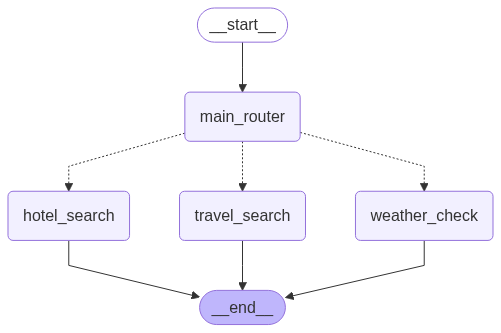

In [ ]:
from IPython.display import display, Image
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [26]:
print('hi')

hi
